In [40]:
import csv
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers

RANDOM_SEED = 42

In [41]:
dataset_test = 'glove_data_test/glove_test_data.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier_glove.keras'
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier_glove.tflite'

In [42]:
NUM_CLASSES = 24

In [43]:
# Directory containing CSV files
directory = 'data_glove'

# Initialize an empty list to store data from all files
data_X = []
data_y = []

# Loop through each file in the directory
for filename in os.listdir(directory):
    if filename.endswith(".csv"):
        file_path = os.path.join(directory, filename)
        # Load data from each file and append to the list
        data_X.append(np.loadtxt(file_path, delimiter=',', dtype='float32', usecols=list(range(300, 325)) + list(range(4, 151))))
        data_y.append(np.loadtxt(file_path, delimiter=',', dtype='float32', usecols=(0)))

# Concatenate data from all files along the first axis
X_dataset = np.concatenate(data_X, axis=0)
y_dataset = np.concatenate(data_y, axis=0)

X_train, X_validation, y_train, y_validation = train_test_split(X_dataset, y_dataset, train_size=0.70, random_state=RANDOM_SEED)
X_test = np.loadtxt(dataset_test, delimiter=',', dtype='float32', usecols=list(range(300, 325)) + list(range(4, 151)))
y_test = np.loadtxt(dataset_test, delimiter=',', dtype='int32', usecols=(0))

In [44]:
X_train_GQ= []
Y_train_GQ=[]
for i, int_value in enumerate(y_train):
    if int_value == 6 or int_value ==15:
        X_train_GQ.append(X_train[i])
        Y_train_GQ.append(y_train[i])
X_train_GQ = np.array(X_train_GQ)
Y_train_GQ = np.array(Y_train_GQ)

X_test_GQ= []
Y_test_GQ=[]
for i, int_value in enumerate(y_test):
    if int_value == 6 or int_value ==15:
        X_test_GQ.append(X_test[i])
        Y_test_GQ.append(y_test[i])
X_test_GQ= np.array(X_test_GQ)
Y_test_GQ = np.array(Y_test_GQ)


X_validation_GQ=[]
Y_validation_GQ=[]
for i, int_value in enumerate(y_validation):
    if int_value == 6 or int_value ==15:
        X_validation_GQ.append(X_validation[i])
        Y_validation_GQ.append(y_validation[i])
X_validation_GQ = np.array(X_validation_GQ)
Y_validation_GQ = np.array(Y_validation_GQ)

print("X train GQ shape: ", X_train_GQ.shape)
print("Y train GQ shape: ", Y_train_GQ.shape)
print("X validation GQ shape: ", X_validation_GQ.shape)
print("Y validation GQ shape: ", Y_validation_GQ.shape)
print("X test GQ shape: ", X_test_GQ.shape)
print("Y test GQ shape: ", Y_test_GQ.shape)

X train GQ shape:  (1397, 172)
Y train GQ shape:  (1397,)
X validation GQ shape:  (603, 172)
Y validation GQ shape:  (603,)
X test GQ shape:  (200, 172)
Y test GQ shape:  (200,)


In [45]:
# Label mapping function
def map_labels(labels):
    return np.array([0 if label == 6 else 1 for label in labels])

# Map labels in the train, validation, and test sets
Y_train_GQ = map_labels(Y_train_GQ)
Y_validation_GQ = map_labels(Y_validation_GQ)
Y_test_GQ = map_labels(Y_test_GQ)

In [46]:
GQ_CLASSES = 2
GQmodel = tf.keras.models.Sequential([
    tf.keras.layers.Reshape((172, 1), input_shape=(172,)),
    tf.keras.layers.Conv1D(16, kernel_size=3, activation='relu', padding='same'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Conv1D(32, kernel_size=3, activation='relu', padding='same'),
    tf.keras.layers.MaxPooling1D(pool_size=10),
    tf.keras.layers.Conv1D(32, kernel_size=3, activation='relu', padding='same'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(GQ_CLASSES, activation='softmax')
])

GQmodel.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=10, verbose=1)

history = GQmodel.fit(
    X_train_GQ,
    Y_train_GQ,
    epochs=1000,
    batch_size=128,
    validation_data=(X_validation_GQ, Y_validation_GQ),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000


C:\Users\zomaa\IdeaProjects\master\venv\Lib\site-packages\keras\src\layers\reshaping\reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


 1/11 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.5078 - loss: 10.0958
Epoch 1: saving model to model/keypoint_classifier/keypoint_classifier_glove.keras
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.5157 - loss: 8.0938 - val_accuracy: 0.6700 - val_loss: 1.1013
Epoch 2/1000
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5547 - loss: 2.9267
Epoch 2: saving model to model/keypoint_classifier/keypoint_classifier_glove.keras
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5658 - loss: 2.7260 - val_accuracy: 0.7313 - val_loss: 0.7927
Epoch 3/1000
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.6406 - loss: 3.4025
Epoch 3: saving model to model/keypoint_classifier/keypoint_classifier_glove.keras
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6045 - loss: 2.0299 - val_accuracy: 0.7612 - val_loss: 0.6844
Epoch 4/1000
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6328 - loss: 0.7920
Epoch 4: saving model to model/keypoint_classifier/keypoint_classifier

In [47]:
val_loss, val_acc = GQmodel.evaluate(X_test_GQ, Y_test_GQ, batch_size = 2)

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step - accuracy: 0.6271 - loss: 1.2457


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


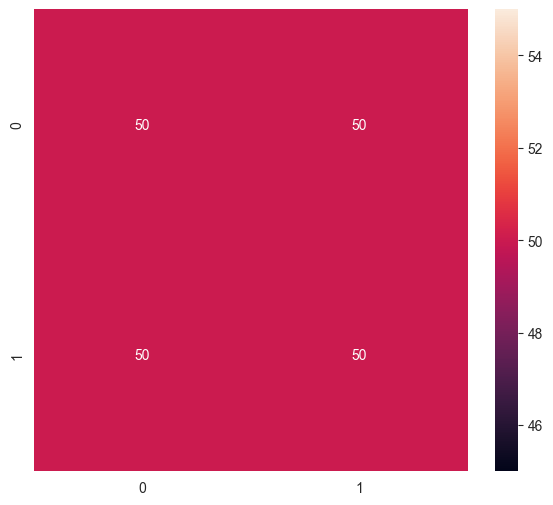

Classification Report
              precision    recall  f1-score   support

           0       0.50      0.50      0.50       100
           1       0.50      0.50      0.50       100

    accuracy                           0.50       200
   macro avg       0.50      0.50      0.50       200
weighted avg       0.50      0.50      0.50       200



In [50]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)

    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)

    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()

    if report:
        print('Classification Report')
        print(classification_report(y_true, y_pred))

Y_pred_GQ = GQmodel.predict(X_test_GQ)
Y_pred_GQ = np.argmax(Y_pred_GQ, axis=1)

print_confusion_matrix(Y_test_GQ, Y_pred_GQ)